###Install and import libraries

In [ ]:
!pip install surprise faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 16.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357241 sha256=82c52c9230ae4e661cd579513069336602d005c4e3fb8f12376589f2442b3537
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
from surprise import accuracy
from faker import Faker
import random
from datetime import datetime, timedelta
from collections import defaultdict

# Инициализация Faker
fake = Faker()


In [ ]:
# Загрузка тегов и создание DataFrame
tags = {
    "Спорт": ["Волейбол", "Футбол", "Теннис", "Бильярд", "Боулинг", "Конный спорт", "Хоббихорсинг", "Фигурное катание", "Спортзал", "Автоспорт", "Боевые искусства", "Горнолыжный спорт", "Бег", "Велоспорт", "Йога", "Плавание", "Другое"],
    "Еда": {
        "Общепит": ["Азиатская кухня", "Грузинская кухня", "Русская кухня", "Европейская кухня", "Фастфуд"],
        "Кофейня": [],
        "Бар": [],
        "Кулинария": [],
        "Другое": []
    },
    "Развлечения": ["Игры", "Компьютерные игры", "Кальян", "Антикафе", "На свежем воздухе", "Астрология", "Книги", "Животные", "Рисование", "Танцы", "Фотография", "Другое"],
    "Культура": ["Театр", "Кинотеатр", "Музей", "Выставка", "Музыка", "Религия", "Другое"],
    "Образование": ["Лекция", "Митап", "Конференция", "Университет", "Школа", "Колледж", "Тренинг", "Курс", "Другое"],
    "Туризм": ["Горы", "Море", "Пустыня", "Лес", "Россия", "Зарубежье", "Другое"],
    "Шопинг": [],
    "Праздник": ["Новый год", "День победы", "Праздник Весны и Труда (1 мая)", "Пасха", "День знаний (1 сентября)", "Международный женский день (8 марта)", "День Защитника Отечества (23 февраля)", "День Святого Валентина (14 февраля)", "Рождество", "Масленица", "Хеллоуин", "Другое"],
    "Семья": [],
    "С друзьями": []
}

# Функция для упрощения структуры тегов и создания карты родителей
def flatten_tags(tag_dict, parent=None):
    flat_tags = []
    parent_map = {}
    for key, value in tag_dict.items():
        main_tag = key if parent is None else f"{parent} - {key}"
        flat_tags.append(main_tag)
        if parent is not None:
            parent_map[main_tag] = parent

        if isinstance(value, list):
            for sub_tag in value:
                sub_tag_with_parent = f"{main_tag} - {sub_tag}"
                flat_tags.append(sub_tag_with_parent)
                parent_map[sub_tag_with_parent] = main_tag
        elif isinstance(value, dict):
            sub_flat_tags, sub_parent_map = flatten_tags(value, main_tag)
            flat_tags.extend(sub_flat_tags)
            parent_map.update(sub_parent_map)

    return flat_tags, parent_map

all_tags, parent_map = flatten_tags(tags)
tag_df = pd.DataFrame({
    'tag_id': range(1, len(all_tags) + 1),
    'tag_name': all_tags
})
tag_df.set_index('tag_id', inplace=True)
tag_name_to_id = {name: idx for idx, name in tag_df['tag_name'].items()}


In [ ]:
# Генерация синтетических пользователей
num_users = 1000
users = [{'user_id': i} for i in range(1, num_users + 1)]
users_df = pd.DataFrame(users)

# Генерация синтетических интересов пользователей
user_interests_list = []
for user_id in range(1, num_users + 1):
    selected_tags = random.sample(all_tags, random.randint(1, 5))
    for tag in selected_tags:
        user_interests_list.append({
            'user_id': user_id,
            'tag_id': tag_name_to_id[tag]
        })
user_interests_df = pd.DataFrame(user_interests_list)

# Генерация синтетических целей
num_goals = 500
goals = []
for i in range(1, num_goals + 1):
    goal_tags = random.sample(all_tags, random.randint(1, 5))
    goal_tags_ids = [tag_name_to_id[tag] for tag in goal_tags]
    goals.append({
        'goal_id': i,
        'user_id': random.randint(1, num_users),
        'tags': goal_tags_ids,
        'publication_date': fake.date_between(start_date='-1y', end_date='today')
    })
goals_df = pd.DataFrame(goals)

# Генерация синтетических историй
num_stories = 1000
stories = []
for i in range(1, num_stories + 1):
    story_tags = random.sample(all_tags, random.randint(1, 5))
    story_tags_ids = [tag_name_to_id[tag] for tag in story_tags]
    stories.append({
        'story_id': i,
        'goal_id': random.randint(1, num_goals),
        'user_id': random.randint(1, num_users),
        'publication_date': fake.date_between(start_date='-1y', end_date='today')
    })
stories_df = pd.DataFrame(stories)

# Генерация синтетических лайков для целей
goal_likes = []
for i in range(1, 2000):
    goal_likes.append({
        'user_id': random.randint(1, num_users),
        'goal_id': random.randint(1, num_goals),
        'like_id': i  # Уникальный like_id
    })
goal_likes_df = pd.DataFrame(goal_likes)

# Генерация синтетических лайков для историй
story_likes = []
for i in range(1, 2000):
    story_likes.append({
        'user_id': random.randint(1, num_users),
        'story_id': random.randint(1, num_stories),
        'like_id': i  # Уникальный like_id
    })
story_likes_df = pd.DataFrame(story_likes)

# Отображение примеров синтетических данных
print(users_df.head())
print(user_interests_df.head())
print(goals_df.head())
print(stories_df.head())
print(goal_likes_df.head())
print(story_likes_df.head())


   user_id
0        1
1        2
2        3
3        4
4        5
   user_id  tag_id
0        1      80
1        1      41
2        1      50
3        1      83
4        2      29
   goal_id  user_id                  tags publication_date
0        1      949                  [53]       2023-08-31
1        2      130  [25, 30, 43, 76, 23]       2023-12-03
2        3      296                  [13]       2023-09-25
3        4      623      [14, 42, 23, 43]       2024-03-18
4        5      847   [25, 57, 24, 8, 32]       2023-07-31
   story_id  goal_id  user_id publication_date
0         1      404      200       2024-06-08
1         2       95      982       2023-11-25
2         3      197      237       2023-11-16
3         4      125      591       2024-03-03
4         5      242      698       2024-01-17
   user_id  goal_id  like_id
0        7      115        1
1      692       87        2
2      236      215        3
3      245       45        4
4      113      236        5
   user_id

###Генерация синтетических данных

In [ ]:
# Функция для рекомендации целей на основе контентно-ориентированной фильтрации (правила)
def recommend_goals_content_based(user_id, user_interests, goals, tag_df):
    user_tags = user_interests[user_interests['user_id'] == user_id]['tag_id'].tolist()
    def tag_match_count(goal_tags):
        return sum(tag in goal_tags for tag in user_tags)
    goals['match_count'] = goals['tags'].apply(tag_match_count)  # Подсчет совпадений тегов
    recommended_goals = goals[goals['match_count'] > 0].sort_values(by='match_count', ascending=False)
    return recommended_goals

# Пример контентно-ориентированной рекомендации для пользователя
example_user_id = 1000  # Используйте действительный ID пользователя в диапазоне
recommended_goals_content = recommend_goals_content_based(example_user_id, user_interests_df, goals_df, tag_df)


In [ ]:
recommended_goals_content

,goal_id,user_id,tags,publication_date,match_count
251,252,270,"[75, 22, 84, 26, 17]",2023-07-22,2
465,466,526,"[17, 42, 75]",2023-07-24,2
363,364,503,"[22, 42, 58]",2023-08-06,2
304,305,593,"[42, 65, 7, 58, 33]",2023-11-11,2
286,287,848,"[65, 4, 70, 60, 61]",2023-07-13,1
...,...,...,...,...,...
181,182,125,"[79, 7]",2024-04-20,1
164,165,605,"[23, 48, 41, 42]",2023-07-21,1
154,155,293,"[49, 81, 22, 26, 13]",2023-08-10,1
142,143,577,[79],2024-02-14,1


In [ ]:
# Подготовка данных для коллаборативной фильтрации
def prepare_cf_data(goal_likes):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(goal_likes[['user_id', 'goal_id', 'like_id']], reader)
    return data

# Выполнение поиска по сетке для настройки гиперпараметров
param_grid = {
    'n_epochs': [10, 20, 30],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
data = prepare_cf_data(goal_likes_df)
gs.fit(data)
best_params = gs.best_params['rmse']
model = SVD(n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
trainset = data.build_full_trainset()
model.fit(trainset)


In [ ]:
# Функция для рекомендации целей на основе коллаборативной фильтрации
def recommend_goals_cf(user_id, model, goals, num_recommendations=10):
    goal_ids = goals['goal_id'].tolist()
    predictions = [model.predict(user_id, goal_id) for goal_id in goal_ids]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_predictions = predictions[:num_recommendations]
    top_goal_ids = [pred.iid for pred in top_predictions]
    recommended_goals = goals[goals['goal_id'].isin(top_goal_ids)]
    return recommended_goals


In [ ]:
# Функция для рекомендации целей на основе гибридной рекомендации
def recommend_goals_hybrid(user_id, user_interests, goals, model, tag_df, content_weight=0.5, cf_weight=0.5, new_fraction=0.1, popular_fraction=0.1, num_recommendations=10):
    # Контентно-ориентированные рекомендации
    content_recommendations = recommend_goals_content_based(user_id, user_interests, goals, tag_df)
    # Рекомендации на основе коллаборативной фильтрации
    cf_recommendations = recommend_goals_cf(user_id, model, goals, num_recommendations)
    # Расчет оценок
    content_recommendations['score'] = content_recommendations['match_count'] * content_weight
    cf_scores = {row.iid: row.est * cf_weight for row in model.test([[user_id, goal_id, 0] for goal_id in cf_recommendations['goal_id']])}
    cf_recommendations = cf_recommendations.copy()  # Избегаем SettingWithCopyWarning
    cf_recommendations['score'] = cf_recommendations['goal_id'].map(cf_scores)
    # Объединение и ранжирование
    combined_recommendations = pd.concat([content_recommendations[['goal_id', 'score']], cf_recommendations[['goal_id', 'score']]])
    combined_recommendations = combined_recommendations.groupby('goal_id').agg({'score': 'sum'}).reset_index()
    combined_recommendations = combined_recommendations.sort_values(by='score', ascending=False).head(num_recommendations)
    # Включение нового и популярного контента
    new_date_threshold = datetime.now().date() - timedelta(days=30)
    new_content = goals[goals['publication_date'] >= new_date_threshold].sample(frac=new_fraction)
    popular_content = goals[goals['goal_id'].isin(goal_likes_df['goal_id'].value_counts().index[:int(len(goal_likes_df) * popular_fraction)])]
    combined_recommendations = combined_recommendations.merge(goals, on='goal_id', how='left')
    combined_recommendations = pd.concat([combined_recommendations, new_content, popular_content]).drop_duplicates('goal_id').head(num_recommendations)
    return combined_recommendations

# Пример гибридной рекомендации для пользователя
recommended_goals_hybrid = recommend_goals_hybrid(example_user_id, user_interests_df, goals_df, model, tag_df)


In [ ]:
recommended_goals_hybrid

,goal_id,score,user_id,tags,publication_date,match_count
0,4,3.0,623,"[14, 42, 23, 43]",2024-03-18,1
1,1,2.5,949,[53],2023-08-31,0
2,3,2.5,296,[13],2023-09-25,0
3,5,2.5,847,"[25, 57, 24, 8, 32]",2023-07-31,0
4,6,2.5,355,"[57, 62, 69, 6]",2023-10-18,0
5,7,2.5,880,[31],2023-11-04,0
6,8,2.5,211,[24],2023-08-06,0
7,9,2.5,690,[84],2024-05-29,0
8,10,2.5,489,"[31, 13, 21]",2023-11-24,0
9,2,2.5,130,"[25, 30, 43, 76, 23]",2023-12-03,0


In [ ]:
# Функция для рекомендации историй на основе гибридной рекомендации
def recommend_stories_hybrid(user_id, user_interests, stories, goals, model, tag_df, content_weight=0.5, cf_weight=0.5, new_fraction=0.1, popular_fraction=0.1, num_recommendations=10):
    # Получение интересов пользователя
    user_tags = user_interests[user_interests['user_id'] == user_id]['tag_id'].tolist()

    # Контентно-ориентированная фильтрация: совпадение тегов целей истории с интересами пользователя
    def tag_match_count(goal_tags):
        return sum(tag in goal_tags for tag in user_tags)
    stories = stories.merge(goals[['goal_id', 'tags']], on='goal_id')
    stories['match_count'] = stories['tags'].apply(tag_match_count)

    content_recommendations = stories[stories['match_count'] > 0].copy()
    content_recommendations.loc[:, 'score'] = content_recommendations['match_count'] * content_weight

    # Рекомендации на основе коллаборативной фильтрации
    cf_recommendations = stories.copy()
    cf_scores = {row.iid: row.est * cf_weight for row in model.test([[user_id, story_id, 0] for story_id in cf_recommendations['story_id']])}
    cf_recommendations.loc[:, 'score'] = cf_recommendations['story_id'].map(cf_scores)

    # Объединение и ранжирование
    combined_recommendations = pd.concat([content_recommendations[['story_id', 'score']], cf_recommendations[['story_id', 'score']]])
    combined_recommendations = combined_recommendations.groupby('story_id').agg({'score': 'sum'}).reset_index()
    combined_recommendations = combined_recommendations.sort_values(by='score', ascending=False).head(num_recommendations)

    # Включение нового и популярного контента
    new_date_threshold = datetime.now().date() - timedelta(days=30)
    new_content = stories[stories['publication_date'] >= new_date_threshold].sample(frac=new_fraction)
    popular_content = stories[stories['story_id'].isin(story_likes_df['story_id'].value_counts().index[:int(len(story_likes_df) * popular_fraction)])]

    # Объединение контентно-ориентированных и коллаборативных рекомендаций с новым и популярным контентом
    combined_recommendations = combined_recommendations.merge(stories, on='story_id', how='left')
    combined_recommendations = pd.concat([combined_recommendations, new_content, popular_content]).drop_duplicates('story_id').head(num_recommendations)

    return combined_recommendations

# Пример гибридной рекомендации для историй
recommended_stories_hybrid = recommend_stories_hybrid(example_user_id, user_interests_df, stories_df, goals_df, model, tag_df)


In [ ]:
recommended_stories_hybrid

,story_id,score,goal_id,user_id,publication_date,tags,match_count
0,840,3.5,364,817,2024-05-07,"[22, 42, 58]",2
1,473,3.5,364,608,2023-07-04,"[22, 42, 58]",2
2,978,3.5,466,379,2024-05-10,"[17, 42, 75]",2
3,961,3.5,252,80,2024-03-10,"[75, 22, 84, 26, 17]",2
4,388,3.5,364,454,2023-06-29,"[22, 42, 58]",2
5,895,3.5,466,493,2023-12-20,"[17, 42, 75]",2
6,631,3.0,190,770,2023-09-09,"[75, 82]",1
7,901,3.0,122,403,2024-01-20,"[39, 75, 11, 15, 1]",1
8,689,3.0,229,543,2024-03-25,"[22, 36, 73]",1
9,897,3.0,143,621,2023-07-19,[79],1


In [ ]:
# Проверка интересов пользователя
user_1000_interests = user_interests_df[user_interests_df['user_id'] == example_user_id]
user_1000_interest_tags = [tag_df.loc[tag, 'tag_name'] for tag in user_1000_interests['tag_id']]
print(f"User 1000 interest tags: {user_1000_interest_tags}")

# Отображение тегов целей, количества лайков и даты публикации
goal_likes_count = goal_likes_df.groupby('goal_id').size().reset_index(name='like_count')
goal_details = recommended_goals_hybrid.merge(goal_likes_count, on='goal_id', how='left')
goal_details['tags'] = goal_details['tags'].apply(lambda x: [tag_df.loc[tag, 'tag_name'] for tag in x])
goal_details = goal_details[['goal_id', 'tags', 'publication_date', 'like_count']]


User 1000 interest tags: ['Еда - Общепит - Грузинская кухня', 'Развлечения - Другое', 'Праздник - День знаний (1 сентября)', 'Праздник - Рождество', 'Туризм - Лес']


In [ ]:
goal_details

,goal_id,tags,publication_date,like_count
0,4,"[Спорт - Бег, Развлечения - Другое, Еда - Обще...",2024-03-18,4.0
1,1,[Образование - Митап],2023-08-31,6.0
2,3,[Спорт - Горнолыжный спорт],2023-09-25,7.0
3,5,"[Еда - Общепит - Фастфуд, Образование - Коллед...",2023-07-31,1.0
4,6,"[Образование - Колледж, Туризм - Горы, Шопинг,...",2023-10-18,4.0
5,7,[Развлечения - Игры],2023-11-04,3.0
6,8,[Еда - Общепит - Европейская кухня],2023-08-06,3.0
7,9,[С друзьями],2024-05-29,2.0
8,10,"[Развлечения - Игры, Спорт - Горнолыжный спорт...",2023-11-24,NaN
9,2,"[Еда - Общепит - Фастфуд, Развлечения, Культур...",2023-12-03,1.0


In [ ]:
# Пример гибридной рекомендации для историй
recommended_stories_hybrid = recommend_stories_hybrid(example_user_id, user_interests_df, stories_df, goals_df, model, tag_df)

# Отображение количества лайков историй и связанных деталей целей
story_likes_count = story_likes_df.groupby('story_id').size().reset_index(name='like_count')
# Переименование столбца тегов в goals_df, чтобы избежать конфликта
goals_df_renamed = goals_df.rename(columns={'tags': 'goal_tags'})
story_details = recommended_stories_hybrid.merge(story_likes_count, on='story_id', how='left')
story_details = story_details.merge(goals_df_renamed[['goal_id', 'goal_tags', 'publication_date']].rename(columns={'publication_date': 'goal_publication_date'}), on='goal_id', how='left')
story_details['goal_tags'] = story_details['goal_tags'].apply(lambda x: [tag_df.loc[tag, 'tag_name'] for tag in x])
story_details = story_details[['story_id', 'like_count', 'goal_id', 'goal_tags', 'goal_publication_date']]


In [ ]:
story_details

,story_id,like_count,goal_id,goal_tags,goal_publication_date
0,840,3.0,364,"[Еда - Общепит - Грузинская кухня, Развлечения...",2023-08-06
1,473,1.0,364,"[Еда - Общепит - Грузинская кухня, Развлечения...",2023-08-06
2,978,6.0,466,"[Спорт - Плавание, Развлечения - Другое, Празд...",2023-07-24
3,961,3.0,252,"[Праздник - День знаний (1 сентября), Еда - Об...",2023-07-22
4,388,3.0,364,"[Еда - Общепит - Грузинская кухня, Развлечения...",2023-08-06
5,895,2.0,466,"[Спорт - Плавание, Развлечения - Другое, Празд...",2023-07-24
6,631,2.0,190,"[Праздник - День знаний (1 сентября), Праздник...",2024-05-24
7,901,NaN,122,"[Развлечения - Рисование, Праздник - День знан...",2023-09-02
8,689,1.0,229,"[Еда - Общепит - Грузинская кухня, Развлечения...",2023-10-22
9,897,1.0,143,[Праздник - Рождество],2024-02-14


In [ ]:
# Функция для расчета Precision и Recall на K
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Оценка модели с использованием кросс-валидации
cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
# Вывод результатов оценки
print(f"Mean RMSE: {cv_results['test_rmse'].mean()}")
print(f"Mean MAE: {cv_results['test_mae'].mean()}")

# Precision и Recall на K
trainset, testset = train_test_split(data, test_size=0.25)
model.fit(trainset)
predictions = model.test(testset)
precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)

# Вывод среднего значения Precision и Recall
print(f"Precision: {sum(precisions.values()) / len(precisions):.4f}")
print(f"Recall: {sum(recalls.values()) / len(recalls):.4f}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1147.31851187.04631152.20741135.01811128.59881150.037820.3320 
MAE (testset)     993.15751043.4900994.6700976.9425966.7193994.995926.3843 
Fit time          0.03    0.03    0.06    0.05    0.06    0.04    0.01    
Test time         0.01    0.00    0.00    0.01    0.01    0.01    0.00    
Mean RMSE: 1150.0378098824717
Mean MAE: 994.995859649123
Precision: 0.9987
Recall: 0.9991


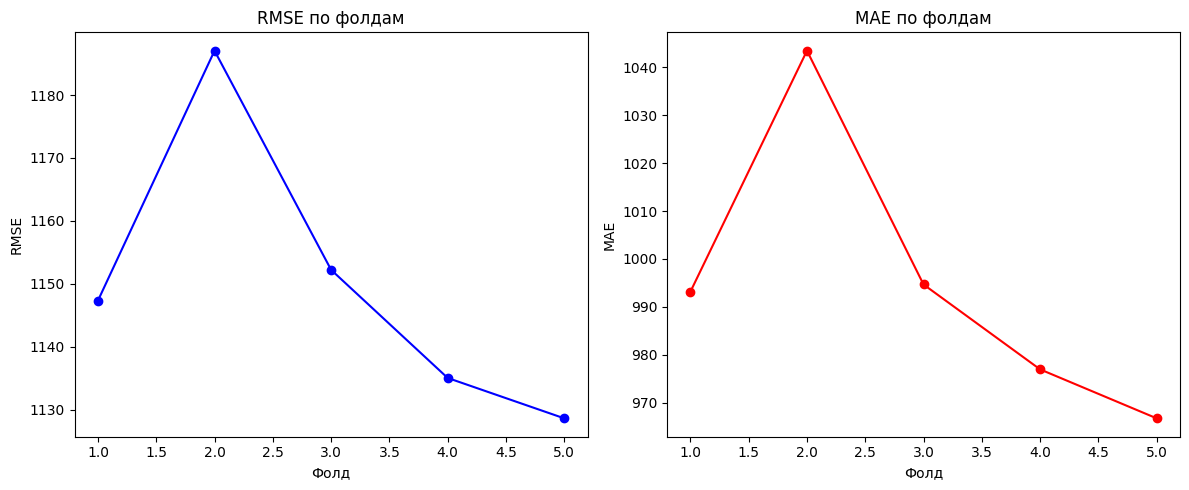

In [ ]:
import matplotlib.pyplot as plt

# Визуализация RMSE и MAE по фолдам
def plot_cv_results(cv_results):
    folds = range(1, len(cv_results['test_rmse']) + 1)

    plt.figure(figsize=(12, 5))

    # RMSE
    plt.subplot(1, 2, 1)
    plt.plot(folds, cv_results['test_rmse'], marker='o', linestyle='-', color='b')
    plt.xlabel('Фолд')
    plt.ylabel('RMSE')
    plt.title('RMSE по фолдам')

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(folds, cv_results['test_mae'], marker='o', linestyle='-', color='r')
    plt.xlabel('Фолд')
    plt.ylabel('MAE')
    plt.title('MAE по фолдам')

    plt.tight_layout()
    plt.show()

# Визуализация результатов кросс-валидации
plot_cv_results(cv_results)


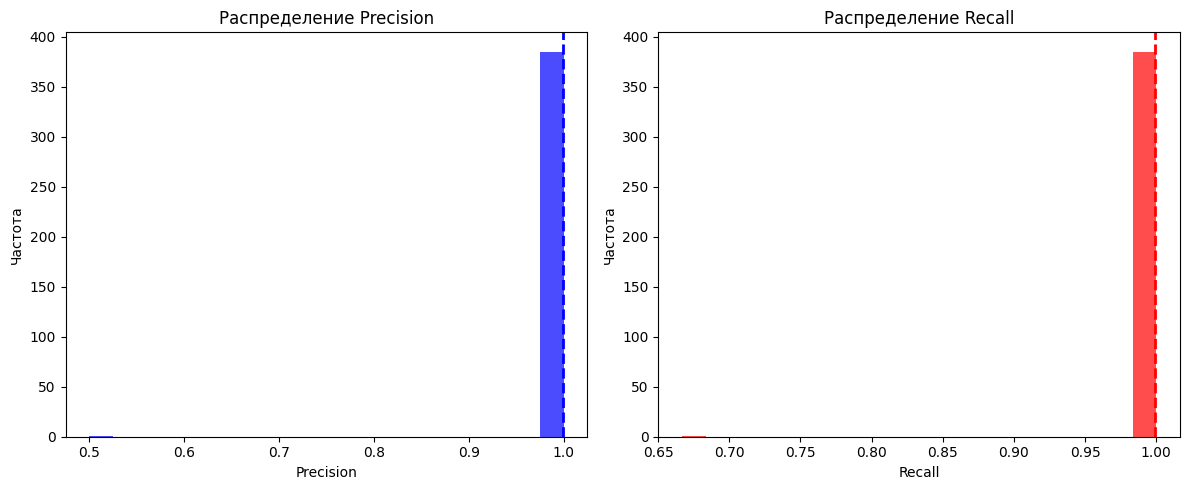

In [ ]:
# Визуализация Precision и Recall
def plot_precision_recall(precisions, recalls):
    users = list(precisions.keys())
    precision_values = list(precisions.values())
    recall_values = list(recalls.values())

    plt.figure(figsize=(12, 5))

    # Precision
    plt.subplot(1, 2, 1)
    plt.hist(precision_values, bins=20, color='b', alpha=0.7, label='Precision')
    plt.axvline(np.mean(precision_values), color='b', linestyle='dashed', linewidth=2)
    plt.xlabel('Precision')
    plt.ylabel('Частота')
    plt.title('Распределение Precision')

    # Recall
    plt.subplot(1, 2, 2)
    plt.hist(recall_values, bins=20, color='r', alpha=0.7, label='Recall')
    plt.axvline(np.mean(recall_values), color='r', linestyle='dashed', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Частота')
    plt.title('Распределение Recall')

    plt.tight_layout()
    plt.show()

# Визуализация Precision и Recall
plot_precision_recall(precisions, recalls)
